<a href="https://colab.research.google.com/github/dalatorrem/Diplomado_Metodos_UCentral_2023/blob/main/Lectura_32_Factor_Analysis_stud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

<p align="center">
  <img src="https://raw.githubusercontent.com/lacamposm/Diplomado_Metodos_UCentral/main/data/images/imagen_ucentral.jpg" alt="logo_Ucentral" width="400px" height="300px">
</p>

## ***Módulos a usar y función adicionales***

In [1]:
%%capture
!pip install factor_analyzer

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
##
from sklearn.preprocessing import StandardScaler  ## Escalar datos.
## El siguiente es el módulo que usaramos para EFA y CFA
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
##
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (15, 9)
plt.style.use('ggplot')
url_base = "https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/"

In [3]:
def view_loadings(fa, df):
  """ Función para ver las cargas como un pandas-DataFrame
      Input: 1. fa: Objeto FactorAnalyzer (from factor_analyzer).
             2. pandas-DataFrame con el que se realizó el FactorAnalyzer.
  """
  loadings, n_factors = fa.loadings_, fa.get_params()["n_factors"]
  columns = [f"factor{i}" for i in range(1,n_factors+1)]
  df_loadings = pd.DataFrame(loadings, index = df.columns, columns = columns)
  return df_loadings

In [4]:
def sedimentacion(fa):
  """ Esta función genera un plot de sedimentación del objeto FA en el argumento
      Input: Objeto fa (from factor_analyzer)
      Ouput: None
  """
  eigenvalues, length_evalue = fa.get_eigenvalues()[0], len(fa.get_eigenvalues()[0])
  varianza, length_var = fa.get_factor_variance()[2], len(fa.get_factor_variance()[0])
  m, n_factors = length_evalue-length_var, fa.get_params()["n_factors"]
  aux_lst = [0 for i in range(0,m)]
  varianza = np.append(list(varianza),aux_lst)
  str_componen = ["factor{}".format(i+1)  for i in range(0,len(eigenvalues))]
  df = pd.DataFrame({"componente": str_componen,
                     "eigenvalor": eigenvalues,
                     "% acumulada": varianza*100})
  fig = px.bar(df, x = "componente",y = "eigenvalor",
               hover_data={"componente":False,
                           "% acumulada":True,
                           "eigenvalor":":.2f",
                           "% acumulada":":.2f"},
               hover_name = "componente",
               title = f"Gráfico de sedimentación con {n_factors} factores."
               )
  fig.add_hline(y=1.0, line_width=3, line_dash="dash", line_color="green")
  fig.show()

In [5]:
def get_communa_uniquess(fa, df_fa):
  communa, uniqueness  = fa.get_communalities(), fa.get_uniquenesses()
  temp1 = pd.DataFrame(communa, columns=["comunalidades"], index = df_fa.columns).T
  temp2 = pd.DataFrame(uniqueness, columns=["especificidad"], index = df_fa.columns).T
  df = pd.concat([temp1,temp2])
  return df

## ***Análisis factorial.***

En muchas áreas de la psicología y otras disciplinas de las ciencias del comportamiento, a menudo no es posible medir directamente los conceptos de interés primario.
Dos ejemplos obvios son la inteligencia y la clase social. En tales casos, el investigador se ve obligado a examinar los conceptos indirectamente mediante la recopilación de información sobre variables que pueden medirse u observarse directamente y que también pueden asumirse de manera realista como indicadores, en algún sentido, de los conceptos de interés. El psicólogo que se interesa por la “inteligencia” de un individuo,
por ejemplo, puede registrar puntajes de exámenes en una variedad de diferentes temas en la expectativa de que estos puntajes dependan de alguna manera de lo que es ampliamente considerado como "inteligencia", pero también están sujetos a errores aleatorios. Un sociólogo, preocupado por la "clase social" de las personas podría plantear preguntas sobre
la ocupación de una persona, antecedentes educativos, propiedad de vivienda, etc, en el supuesto de que estos reflejan el concepto que realmente le interesa.



Tanto la "inteligencia" como la "clase social" son lo que generalmente se conoce como ***variables latentes***, es decir, conceptos que no se pueden medir directamente pero que se puede suponer que se relacionan con una serie de ***variables medibles o manifiestas***. El método de análisis más generalmente utilizado para ayudar a descubrir las relaciones entre las variables latentes asumidas y las variables manifiestas es el análisis factorial. El modelo en el que se basa el método es esencialmente el de regresión múltiple, excepto que ahora las variables manifiestas son retrocedidas en las ***variables latente no observable*** (a menudo referidas en este contexto como factores comunes), de modo que la estimación de los coeficientes de regresión correspondientes (cargas factoriales) no es
posible. Un punto a destacar desde el principio es que el análisis factorial viene en dos variedades distintas:

1. El análisis factorial exploratorio, que se utiliza para investigar la relación entre ***variables manifiestas y factores*** sin hacer cualquier suposición sobre qué variables manifiestas están relacionadas con qué factores.

2. El análisis factorial confirmatorio que se utiliza para probar si un modelo de análisis factorial específico postulado a priori proporciona un ajuste adecuado para la covarianzas o correlaciones entre las variables manifiestas.

## ***Ejemplo 1.***

En el escenario para el modelo de análisis factorial, iniciamos con un solo factor. Pensemos en tres variables que son las calificaciones de exámenes en tres idiomas:  clásico ($X_1)$, Francés ($X_2$) e inglés ($X_3$), supongamos además que apartir de allí se obtiene la siguiente matriz de correlación:

$$\begin{equation}
\begin{bmatrix}
1 & 0.83  & 0.78 \\
0.83 & 1 & 0.67 \\
0.78 & 0.67 & 1
\end{bmatrix}
\end{equation}$$

Donde la matriz sigue el orden de clásico a inglés

Si asumimos un solo factor, entonces el modelo de un solo factor se especifica de la siguiente manera:

$$\begin{equation}
\begin{split}
x_1 & = λ_1f + u_1\\
x_2 & = λ_2f + u_2\\
x_3 & = λ_3f + u_3\end{split}
\end{equation}$$

Vemos que el modelo involucra esencialmente la regresión lineal simple de cada variable observada en el único ***factor común***. En este ejemplo, la variable latente subyacente o el factor común, $f$, posiblemente podría equipararse con inteligencia o capacidad intelectual general. Los términos $λ_1$, $λ_2$ y $λ_3$ que son
esencialmente, los coeficientes de regresión se conocen, en este contexto, como ***cargas factoriales***, y los términos $u_1$, $u_2$ y $u_3$ representan términos de ***perturbación aleatoria (ruido)*** y tendrá pequeñas variaciones si su variable observada asociada está estrechamente relacionada a la ***variable latente*** subyacente. La variación en $u_i$ en realidad consta de dos partes, la medida en que la habilidad de un individuo en literatura clásica, digamos, difiere de
su habilidad general y la medida en que el examen en literatura clásica es solo una medida aproximada de su habilidad en el tema. En la practica no se intenta desentrañar estas dos partes.

### ***El $k$-modelo de análisis factorial***

La base del análisis factorial es un modelo de regresión que vincula las variables manifiestas con un conjunto de ***variables latentes no observadas (y no observables)***. En esencia, el modelo asume que las relaciones observadas entre las variables manifiestas (medidas por sus covarianzas o correlaciones) son el resultado de las relaciones de estas variables con las ***variables latentes***.

***Nota:*** Ya que son las covarianzas o correlaciones de las variables manifiestas fundamentales para el análisis factorial, se puede, en la descripción de las matemáticas del método dado, asumir
que todas las variables manifiestas tienen media cero.


Supongamos que tenemos un conjunto de variables observadas o manifiestas: $x_1, x_2, . . . , x_q$, se supone que están vinculadas a $k$ ***variables latentes no observadas o factores comunes*** $f_1, f_2,…, f_k$, donde $k < q$, via la forma:

$$\begin{equation}
\begin{split}
x_1 & = λ_{11}f_1 + λ_{12}f_2 + \cdots + λ_{1k}f_k + u_1\\
x_2 & = λ_{21}f_1 + λ_{22}f_2 + \cdots + λ_{2k}f_k + u_2\\
...\\
x_q & = λ_{q1}f_1 + λ_{q2}f_2 + \cdots + λ_{qk}f_k + u_q\end{split}
\end{equation}$$

Los $λ_{ij}$ son esencialmente los coeficientes de regresión de las variables $x_i$ en los
factores comunes, pero en el contexto del análisis factorial estos coeficientes de regresión se conocen como ***cargas factoriales*** y muestran cómo cada variable observada, $x_i$, depende de los factores comunes. Las ***cargas factoriales*** se utilizan en la interpretación de los factores; es decir, los valores más grandes relacionan un factor con la correspondiente
variables observadas y de éstas podemos a menudo, pero no siempre, inferir una descripción significativa de cada factor.

Los elementos $f_i$ son llamados los ***factores comunes*** y los elementos $u_i$ ***factores únicos o específicos***

Las ecuaciones de regresión anteriores se pueden escribir de manera más concisa como:

$$X = Λf+u$$

Suponemos que los términos de ***perturbación aleatoria (ruido)***, $u_1,...,u_q$, no están correlacionados
entre sí ni con los factores $f_1,...,f_k$, (los elementos de $u$ son específicos de cada $x_i$ y, por lo tanto, generalmente se conocen mejor en este contexto como ***factores específicos***). Los dos supuestos implican que, dados los valores de los ***factores comunes***, las variables manifiestas son independientes; es decir, las correlaciones de las variables observadas surgen de sus relaciones con los factores comunes. Debido a que los factores no se observan, podemos fijar sus ubicaciones y escalas arbitrariamente y supondremos que ocurren en forma estandarizada con media 0 y desviación estándar 1. Supondremos también, que los factores no están correlacionados entre sí, en cuyo caso las cargas factoriales son las correlaciones de las variables manifiestas y los factores. Con estos supuestos adicionales sobre los factores, el modelo de análisis factorial implica que la varianza de la variable $x_i$, $σ^2_i$ , está dado por:

 $$σ^2_i = ∑_{j=1}^{k}λ_{ij}^{2}+ψ_{i}$$

donde $\psi_i$ es la varianza de $u_i$

De la expresión anterior la varianza de $x_i$ puede descomponerse en dos partes, la primera:

$$λ_{i1}^{2}+λ_{i2}^{2}+⋯+λ_{ik}^{2}=∑_{j=1}^{k}λ_{ij}^{2}=h_i^2$$

se denomina ***comunalidad*** y representa la varianza de $x_i$, compartida con las otras variables a travéz de los ***factores comunes*** $f$. La segunda parte $ψ_{i}$, representa la ***variabilidad exclusiva*** de $x_{i}$, es decir, la varianza que no es compartida con las otras variables, esta se llama ***especificidad*** o la ***varianza única***.

## ***Volvamos al primer ejemplo***

De retorno al modelo simple de un solo factor, tenemos en este caso que la estimación de las cargas factoriales y las varianzas específicas es muy simple, la razón es que en este caso el número de parámetros en el modelo, 6 ***(tres cargas factoriales y tres varianzas específicas)***, es igual a el número de elementos independientes en la matriz $S$ de correlaciones (las tres correlaciones y los tres varianzas estandarizadas diagonales), así equiparando elementos con la matriz de correlación observada a los valores correspondientes predichos por el modelo de factor único, podremos encontrar estimaciones de $λ_1,λ_2,λ_3$, $ψ_1,ψ_2$ y $ψ_3$ tales que el modelo se ajusta de buena manera.

Del modelo general y de los supuestos, se observa que se debe resolver:

$$S=ΛΛ^{t} + Ψ$$

Las seis ecuaciones derivadas de la igualdad matricial
implícita en el modelo de análisis factorial son:

$$\begin{align*}
1&=\lambda_{1}^{2}+\psi_1 &  1&=\lambda_{2}^{2}+\psi_2              &  1&=\lambda_{3}^{2}+\psi_3\\
0.83&=λ_1λ_2         &  0.76&=λ_1λ_3   &  0.67&=λ_2λ_3
\end{align*}$$



Cuyas soluciones son:

$$\begin{align*}
\lambda_{1}&=0.99 &  \lambda_{2}&=0.84&  \lambda_{3}&=0.79\\
\psi_{1}&=0.02  &  \psi{2}&=0.30&  \psi{3}&=0.38
\end{align*}$$

### ***Estimación de los parámetros en el análisis k-factorial***

Para aplicar el modelo de análisis factorial descrito a una muestra de observaciones multivariadas, necesitamos estimar los parámetros del modelo de alguna manera. Estos parámetros son las ***cargas factoriales*** y las ***varianzas específicas***, por lo que el problema de estimación en el análisis factorial es esencialmente el de encontrar $Λ$ ***(la matriz de carga factorial estimada)*** y $Ψ$ ***(la matriz diagonal que contiene
las varianzas específicas estimadas)***, que, asumiendo el modelo factorial descrito, reproduzca con la mayor precisión posible la matriz de covarianza de la muestra,
S. Esto implica:

$$S=ΛΛ^{t}+Ψ$$

Dada una estimación de la matriz de ***cargas factoriales***, $Λ$, es claramente sensato
estimar las varianzas específicas como:

$$ψ_i = s_{i}^{2}-∑_{j=1}^{k}\lambda_{ij}^{2}, \text{ $j=1,2,...,q$}$$

así, los términos de la diagonal en $S$ se estiman exactamente.

En la práctica, el modelo factorial debe tener menos ***variables latentes*** que los datos originales, se busca entonces una descripción genuinamente parsimoniosa de los datos. Para ello se necesitan datos y métodos de estimación que traten de hacer que la matriz de covarianza predicha por el modelo factorial sea lo más cercana posible en algún sentido a la matriz de covarianza observada de las variables manifiestas. Hay tres principales métodos de estimación:

1. Análisis factorial principal.
2. Análisis factorial de máxima verosimilitud
3. Análisis factorial MINRES.

### ***Estimación del número de factores.***

La decisión sobre cuántos factores, $k$, se necesitan para dar una representación adecuada de las covarianzas o correlaciones observadas es generalmente crítica cuando
se ajusta un modelo de análisis factorial exploratorio. Soluciones con $k=m$ y $k=m+1$ a menudo producirá cargas factoriales bastante diferentes para todos los factores,
a diferencia de un análisis de componentes principales, en el que los primeros $m$ componentes son idéntico en cada solución. Muchos autores señalan que: _"con muy pocos factores habrá demasiadas cargas altas, y con demasiados factores, los factores pueden estar fragmentados y ser difíciles de interpretar de manera convincente."_ La elección de $k$ se puede hacer examinando soluciones correspondientes a diferentes valores de $k$ y decidiendo subjetivamente cuál puede dar interpretación convincente. Otra posibilidad es usar el método de diagrama de sedimentación, aunque la utilidad de este método no está tan claro en el análisis factorial ya que los valores propios representan varianzas de los componenetes principales, no factores.

Acá, tomaremos el método comunmente más usado y consiste en escoger $k$ como el número de valores propios mayores que la media de ellos. Como trabajamos factores estimados con la matriz de correlación el promedio es 1.

### ***Rotación de factores***

El objetivo con el análisis factorial es la obtención de una estructura simple de factores o variables latentes, las cuales puedan ser identificadas por el
investigador. Cuando los modelos para los factores estimados no revelen su significado, una rotación ortogonal u oblicua de éstos puede ayudar en tal sentido.

En la rotación ortogonal los factores son girados manteniendo la ortogonalidad entre éstos (rotación “rígida”), mientras que con la rotación oblicua no.

La interpretación de las ponderaciones o coeficientes factoriales es adecuada si cada variable pondera altamente en sólo un factor determinado, y si cada uno
de éstos es positivo y grande o cercano a cero. Las variables se particionan en correspondencia con cada uno de los factores; las variables que se puedan
asignar a más de un factor se dejan de lado. La interpretación de un factor es la característica común, media o genérica sobre las variables cuya carga es grande.

Tenemos varios tipos de [rotaciones](https://personal.utdallas.edu/~herve/Abdi-rotations-pretty.pdf):

1. varimax (rotación ortogonal).
2. promax (rotación oblicua).
3. oblimin (rotación oblicua rotación).
4. oblimax (rotación ortogonal rotación).
5. quartimin (rotación oblicua rotación).
6. quartimax (rotación ortogonal).
7. equamax (rotación ortogonal).


### ***¿Cuándo es adecuado hacer un análisis factorial?***

El análisis factorial tiene razón de ser cuando las variables están altamente correlacionadas; de otra manera, lo mismo que se muestra para componentes
principales, es decir, la búsqueda de factores comunes no tendrá resultados satisfactorios. Luego, ¿son los datos apropiados para realizar el análisis factorial?.  La mayor parte de las medidas para este fin son de tipo heurístico o empíricas. Una estrategia es el examen de la matriz de correlación, pues una correlación
alta entre las variables indica que estas pueden ser agrupadas en conjuntos de variables. De manera que la búsqueda se dirige hacia aquellas características
o atributos englobadas o agregadas en cada uno de estos conjuntos: a esto se le denomina ***factores o variables latentes***. Una correlación baja entre las
variables indica que las variables no tienen mucho en común. En el caso de disponer de un número grande de variables, la apreciación visual de la matriz
de covarianzas puede tornarse pesada o de difícil lectura. Por lo anterior, una primera inspección es sobre el determinante de la matriz de covarianzas; un valor bajo de éste señala baja correlación lineal entre las variables, pero no debe ser cero (matriz singular), caso en el cual se presentan algunas indeterminaciones en los cálculos, pues esto es un indicador de que
algunas variables son linealmente dependientes.

Pueden emplearse las técnicas:

1. ***Prueba de esfericidad de Barlett:***.

En esta prueba se tiene como hipótesis nula
$$H_{0}:corr(X)=I$$

En caso de rechazar $H_{o}$, se debería tener una correlación alta entre las variables observadas.

2. ***Medida de adecuación de la muestra de Kaiser:***

Llamada ***Kaiser-Meyer-Olkin, (KMO)***, es un indicador que mide la adecuación de un conjunto de datos para el desarrollo de un análisis factorial sobre ellos. Se trata de una medida de la homogeneidad de las variables, (Kaiser 1967). Se recomienda valores mayores a 0.6 para que sea adecuado realizar este análisis.

## ***Ejemplo 2.***

Consideremos el dataset `USArrests.csv`, en él se tiene 4 variables:

1. Murder (Asesinatos).
2. Assault (Asaltos).
3. UrbanPop (Población urbana en %).
4. Rape (Violación).

Los delitos están medidos en tasas por cada 100 mil habitantes, de todos los estados en EE.UU.

Para realizar el análisis factorial vamos a hacer uso del módulo [factor_analyzer](https://factor-analyzer.readthedocs.io/en/latest/)

In [6]:
## Importamos la información
df_FA = "USArrests.csv"
df = pd.read_csv(url_base + df_FA, index_col = 0)
df.head()

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [7]:
## Descriptivos básicos de la data.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Murder,50.0,7.788,4.355510,0.8,4.075,7.25,11.250,17.4
Assault,50.0,170.760,83.337661,45.0,109.000,159.00,249.000,337.0
UrbanPop,50.0,65.540,14.474763,32.0,54.500,66.00,77.750,91.0
Rape,50.0,21.232,9.366385,7.3,15.075,20.10,26.175,46.0


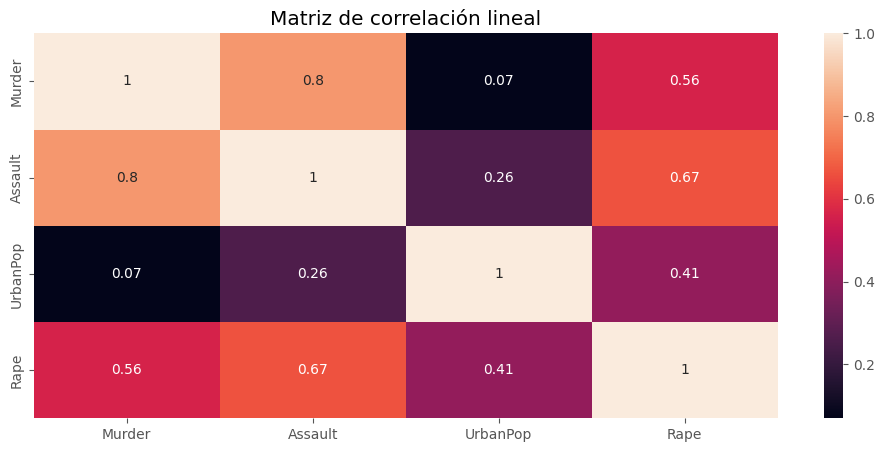

In [8]:
## Matriz de correlación de Pearson.
plt.figure(figsize = (12,5))
sns.heatmap(df.corr(), annot = True)
plt.title("Matriz de correlación lineal")
plt.show()

Vemos una alta correlación entre las variables, destaca el alto valor entre:

- Asaltos y Asesinatos.
- Asaltos y Violaciones.
- Asesinatos y Violaciones.

Quizá estos 3 podrian formar una ***variable latente.***

***Paso 1.***

Escalar la información.

In [9]:
scaler = StandardScaler()            ## Estandarizar el dataset.
scaler.fit(df)                       ## Ajustar el escalador
scaled_data = scaler.transform(df)   ## Información escalada.

***Paso 2.***

Verificar que sea viable un análisis factorial.

In [10]:
## Calcule el criterio de Kaiser-Meyer-Olkin para el dataset. Esta estadística representa
## el grado en que cada variable observada es predicha, sin error, por las demás variables
## del conjunto de datos. En general, un KMO < 0,6 se considera inadecuado.
kmo_item, kmo_value = calculate_kmo(scaled_data)
kmo_value

0.6538150062740203

Como obtenemos un valor mayor a 0.6, procede un análisis factorial.

In [11]:
## Esfericidad de Barlett: Prueba la hipótesis de que la matriz de correlación es igual a la matriz
## identidad. ----> H0: La matriz de correlaciones poblacionales es igual a I.
##            ----> H1: La matriz de correlaciones poblacionales no es igual a I.
## La fórmula para la prueba de esfericidad de Bartlett es:
##  −1∗(n−1−((2p+5)/6))∗ln(det(R))
## Donde R det(R) es el determinante de la matriz de correlación, y p es el número de variables.
stats, p_value = calculate_bartlett_sphericity(scaled_data)
print("El p-valor para la prueba de Barlett es: {:.4f}".format(p_value))

El p-valor para la prueba de Barlett es: 0.0000


Como el $p$-value es pequeño rechazamos $H_0$. Es decir, vamos por un buen camino para realizar nuestro análisis factorial.

***Paso 3.***

In [12]:
fa = FactorAnalyzer(n_factors=4, rotation=None) ## Instanciamos un objeto FactorAnalyzer
fa.fit(scaled_data)                             ## Ajustamos el análisis factorial.

FactorAnalyzer(n_factors=4, rotation=None, rotation_kwargs={})

***Paso 4.***

Analizamos las salidas.

In [13]:
## Vemos las cargas.
loadings = view_loadings(fa,df)
loadings

,factor1,factor2,factor3,factor4
Murder,0.843704,-0.374741,-0.073213,0.0
Assault,0.919370,-0.103672,0.172831,0.0
UrbanPop,0.331679,0.548848,0.062696,0.0
Rape,0.784798,0.292359,-0.150257,0.0


Cada columna en la salida anterior es
un factor supuesto, y cada número debajo de él corresponde a la carga.

1. ***factor1:*** El primer factor parece ser compuesto principalmente de asesinato, asalto y violación, con cargas de 0,84, 0,91 y 0,78, respectivamente. Esta ***variable latente se podría pensar como indice delictivo***.

2. ***factor2 y factor3:*** El segundo y tercer factores no están muy bien definidos teniendo relativamente cargas pequeñas (aunque se podría argumentar a favor de un segundo factor).

Podemos obtener los valores propios de la matriz de correlación, que reflejará los obtenidos en PCA:

In [14]:
## Eigenvalores y eigenvectores de la matriz de correlacion.
eval, evec = fa.get_eigenvalues()
eval

array([2.48024158, 0.98976515, 0.35656318, 0.17343009])

Seguido podemos observar las ***comunalidades*** para cada variable a través de la solución factorial:

In [15]:
## Comunalidad: Varianza compartida con las otras variables a travéz de los factores.
fa.get_communalities()

array([0.85762759, 0.88586043, 0.41517638, 0.72395827])

Podemos ver en este caso:

1. Para la variable `UrbanPop` no hay un porcentaje alto de la variabilidad compartida con las otras variables, esto podría determinar que hay una bunea representación de esta variable en el modelo.

2. Hay cuatro ***comunalidades*** porque hay cuatro variables observadas (no confunda con que tenemos tres factores). Tenga en cuenta que la suma de las cargas al cuadrado en la solución factorial es igual a la ***comunalidad*** calculada.

In [16]:
## Comunalidad variable "Murder"
sum(loadings.loc["Murder"]**2)

0.8576275919200913

In [17]:
## Todas las comunalidades
loadings.apply(lambda x: sum(x**2), axis = 1)

Murder      0.857628
Assault     0.885860
UrbanPop    0.415176
Rape        0.723958
dtype: float64

In [18]:
## Varianza específica.
loadings.apply(lambda x: 1-sum(x**2), axis = 1)

Murder      0.142372
Assault     0.114140
UrbanPop    0.584824
Rape        0.276042
dtype: float64

### ***rotación varimax***

Acá nuevamente obtendremos una solución de tres factores. La idea de la rotación aquí será para rotar las cargas de modo que los factores permanezcan ortogonales. Varimax intentará maximizar la varianza en las cargas para un factor dado, lo que
se traduce en aumentar aún más las cargas altas y minimizar las cargas más pequeñas.
Dado que los ejes originales del análisis factorial son en verdad arbitrarios, la rotación en factor
el análisis es permisible y, en un sentido fuerte, los nuevos ejes tienen tanta "verdad" para
ellos como los ejes originales. ¿Qué determinará la justificación última respecto de
si la rotación fue exitosa o útil? Si ayuda a tener más sentido de la solución factorial, que debe ser informada por el juicio del investigador.

In [19]:
## Rotación varimax.
fa_varimax = FactorAnalyzer(n_factors = 3,rotation="varimax",)
fa_varimax.fit(scaled_data)

FactorAnalyzer(rotation='varimax', rotation_kwargs={})

In [20]:
loadings

,factor1,factor2,factor3,factor4
Murder,0.843704,-0.374741,-0.073213,0.0
Assault,0.919370,-0.103672,0.172831,0.0
UrbanPop,0.331679,0.548848,0.062696,0.0
Rape,0.784798,0.292359,-0.150257,0.0


In [21]:
view_loadings(fa_varimax, df)

,factor1,factor2,factor3
Murder,0.915165,0.027628,0.139060
Assault,0.880368,0.320204,-0.091006
UrbanPop,0.059095,0.641426,-0.016038
Rape,0.562926,0.595177,0.229863


Notemos que:

1. La ***rotación varimax*** tuvo el efecto de hacer a la variable UrbanPop bastante irrelevante para el primer factor, disminuyendo la carga de 0,33 en la solución original a solo 0,005 en la rotación. Sin embargo, la estructura total para el primer factor permanece bastante intacta, ya que todavía se compone de
asesinato, asaltos y violación.

2. Para el segundo factor, las variables `UrbanPop` y `Rape` son relativamente dominante en tamaño.

3. En ambas soluciones, no se puede justificar un tercer factor, ya que en ambas soluciones, no rotadas y rotadas, las cargas son bastante pequeñas. Por lo tanto, dependiendo de la postura teórica de uno o lo que uno esperaba ver de la solución, se puede hacer un caso
para una solución de un factor o de dos factores.

In [22]:
## Comunalidades.
fa_varimax.get_communalities()

array([0.85762759, 0.88586043, 0.41517638, 0.72395827])

Vemos que `UrbanPop` es la variable menos relevante para
la solución factorial pues tiene una comunalidad de solo 0.41, mientras que las comunalidades de las otras variables son relativamente fuertes. Es decir, el `UrbanPop` no se explica tan bien por la solución factorial como las demás variables sujetas al análisis.

## ***Ejemplo 3.***

Vamos a considerar el dataset `paises.txt`.

In [23]:
## Importamos el dataset.
data_paises = "paises.txt"
df_paises = pd.read_csv(url_base + data_paises, sep = " ", on_bad_lines='skip')
df_paises.head()

,m0,m25,m50,m75,w0,w25,w50,w75
Algeria,63,51,30,13,67,54,34,15
Cameroon,34,29,13,5,38,32,17,6
Madagascar,38,30,17,7,38,34,20,7
Mauritius,59,42,20,6,64,46,25,8
Reunion,56,38,18,7,62,46,25,10


Los datos anteriores muestran la esperanza de vida en años por país, edad y sexo (w=woman, m=men). Los datos se refieren a la esperanza de vida en los años 1960. En el DataFrame los nombres de los países son los índices y las variables en las columnas.

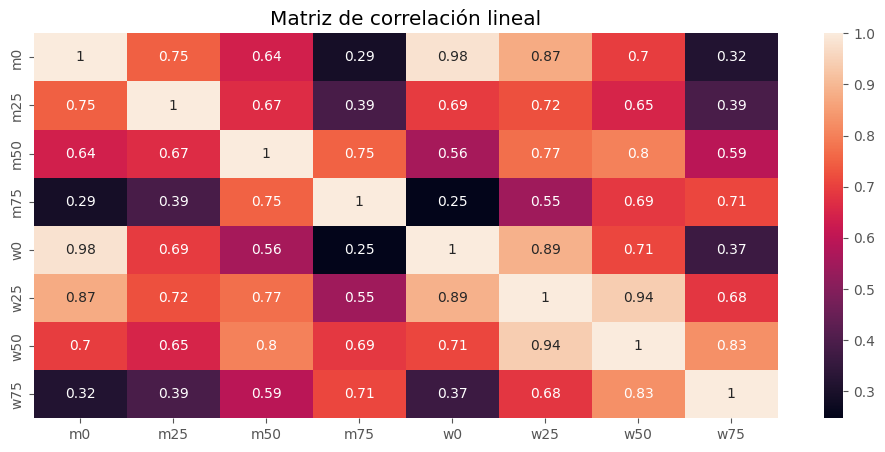

In [24]:
plt.figure(figsize = (12,5))
sns.heatmap(df_paises.corr(), annot = True)
plt.title("Matriz de correlación lineal")
plt.show()

In [25]:
## Rutina habitual EFA.
scaler = StandardScaler()
scaler.fit(df_paises)
scaled_data = scaler.transform(df_paises)

In [26]:
## Calculo de KMO.
kmo_all, kmo_value = calculate_kmo(scaled_data)
kmo_value

0.794062071118025

In [27]:
## Esfericidad de Barlett.
stats, p_value = calculate_bartlett_sphericity(scaled_data)
print("El p-valor de la prueba de Barlett es: {:.3f}".format(p_value))

El p-valor de la prueba de Barlett es: 0.000


Estamos en condiciones de realizar un análisis factorial.

Vamos a considerar inicialmente el análisis factorial con rotación ***varimax*** y con el método de máxima verosimilitud:

In [28]:
## Instanciamos un objeto FactorAnalyzer
fa_vari = FactorAnalyzer(n_factors=3, rotation = "varimax", method = "ml", )
fa_vari.fit(scaled_data)

FactorAnalyzer(method='ml', rotation='varimax', rotation_kwargs={})

In [29]:
## comunalidades
get_communa_uniquess(fa_vari,df_paises).round(4)

,m0,m25,m50,m75,w0,w25,w50,w75
comunalidades,0.9952,0.6383,0.9337,0.7123,0.9951,0.9889,0.9799,0.854
especificidad,0.0048,0.3617,0.0663,0.2877,0.0049,0.0111,0.0201,0.146


In [30]:
## Varianza factores, variabilidad y variabilidad acumulada.
pd.DataFrame(fa_vari.get_factor_variance(),columns = ["Factor1","Factor2","Factor3"],
             index = ["SS loadings", "Portion_Var","Cumulative_Var"])

,Factor1,Factor2,Factor3
SS loadings,3.374631,2.082446,1.640296
Portion_Var,0.421829,0.260306,0.205037
Cumulative_Var,0.421829,0.682135,0.887172


In [31]:
## Vemos las cargas.
factores = view_loadings(fa_vari,df_paises)
factores

,factor1,factor2,factor3
m0,0.963953,0.121610,0.226231
m25,0.646268,0.168941,0.438290
m50,0.429547,0.353620,0.790045
m75,0.079992,0.524554,0.656276
w0,0.970273,0.217068,0.080928
w25,0.764143,0.555873,0.309877
w50,0.535841,0.729269,0.401149
w75,0.156155,0.866583,0.280452


In [32]:
factores.sort_values(by="factor1", ascending = False)

,factor1,factor2,factor3
w0,0.970273,0.217068,0.080928
m0,0.963953,0.121610,0.226231
w25,0.764143,0.555873,0.309877
m25,0.646268,0.168941,0.438290
w50,0.535841,0.729269,0.401149
m50,0.429547,0.353620,0.790045
w75,0.156155,0.866583,0.280452
m75,0.079992,0.524554,0.656276


In [33]:
factores.sort_values(by="factor2", ascending = False)

,factor1,factor2,factor3
w75,0.156155,0.866583,0.280452
w50,0.535841,0.729269,0.401149
w25,0.764143,0.555873,0.309877
m75,0.079992,0.524554,0.656276
m50,0.429547,0.353620,0.790045
w0,0.970273,0.217068,0.080928
m25,0.646268,0.168941,0.438290
m0,0.963953,0.121610,0.226231


In [34]:
factores.sort_values(by="factor3", ascending = False)

,factor1,factor2,factor3
m50,0.429547,0.353620,0.790045
m75,0.079992,0.524554,0.656276
m25,0.646268,0.168941,0.438290
w50,0.535841,0.729269,0.401149
w25,0.764143,0.555873,0.309877
w75,0.156155,0.866583,0.280452
m0,0.963953,0.121610,0.226231
w0,0.970273,0.217068,0.080928


Valores cercanos a cero (m75 en el factor1, w0 en el factor3) son cargas insignificantes y no se deben tener en cuenta para ese factor.

1. Al examinar las cargas factoriales estimadas, vemos que el primer factor está dominado por la esperanza de vida al nacer para tanto hombres como mujeres; tal vez este factor podría denominarse: ***'fuerza vital al nacer'***.

2. El segundo refleja las expectativas de vida a edades más avanzadas de mujeres, y podríamos etiquetarlo como: ***'fuerza vital entre las mujeres'***.

3. El tercer factor de la rotación varimax tiene sus cargas más altas para las esperanzas de vida de los hombres de 50 y 75 años y en la misma vena podría etiquetarse como: ***'fuerza vital para hombres'***.

***Nota:*** Los analistas de factores a menudo pueden ser extremadamente creativos.

Las puntuaciones factoriales estimadas se encuentran de la siguiente manera:

In [35]:
### Puntuaciones factoriales
pd.DataFrame(fa_vari.transform(scaled_data),columns = ["new_feature1","new_feature2", "new_feature3"])

,new_feature1,new_feature2,new_feature3
0,-0.262323,1.932366,1.947490
1,-2.828497,-0.735349,-1.878254
2,-2.852813,-0.825005,-0.012325
3,0.143336,-0.295065,-0.872848
4,-0.199602,0.482158,-1.576111
5,0.373443,0.842705,-0.561237
6,-1.045575,-0.081979,-0.665025
7,0.961830,0.065076,-0.935165
8,-0.876752,3.651146,-0.370445
9,1.265888,0.300544,-0.277970


Podemos usar las puntuaciones para proporcionar la gráfica de los datos:

In [36]:
temp = pd.DataFrame(fa_vari.transform(scaled_data),
                    columns = ["new_feature1","new_feature2", "new_feature3"])
px.scatter(temp,x = "new_feature1", y = "new_feature2", text=df_paises.index)

In [37]:
temp = pd.DataFrame(fa_vari.transform(scaled_data),
                    columns = ["new_feature1","new_feature2", "new_feature3"])
px.scatter(temp,x = "new_feature1", y = "new_feature3", text=df_paises.index)

In [38]:
temp = pd.DataFrame(fa_vari.transform(scaled_data),
                    columns = ["new_feature1","new_feature2", "new_feature3"])
px.scatter(temp,x = "new_feature2", y = "new_feature3", text=df_paises.index)

A lo largo del primer eje  se refleja la ***'fuerza vital al nacer'*** que va desde ***Camerún*** y Madagascar a países como ***Estados Unidos***. En el tercer eje ***Argelia*** destaca porque tiene una alta esperanza de vida entre los hombres a edades más altas, con ***Camerún*** en el extremo inferior de la escala con una vida baja
Expectativa para hombres mayores de 50 años.

## ***Ejercicio en clase:***

Vamos a considerar el dataset en el archivo `stock_exer_data.txt`. Este dataset muestra el semanario de las tasas de rendimiento semanales de cinco acciones (Allied Chemical, du Pont, Union Carbide, Exxon y Texaco) que cotizan en la Bolsa de Valores de Nueva York período comprendido entre enero de 1975 y diciembre de 1976. Las tasas de rendimiento se definen como (precio de cierre del viernes actual - precio de cierre del viernes anterior precio de cierre)/(precio de cierre del viernes anterior), ajustado por división de acciones y dividendos. Las observaciones en 100 semanas sucesivas parecen estar distribuidas independientemente, pero las tasas de retorno entre las acciones están correlacionadas, ya que, como era de esperar, las acciones tienden a moverse juntas en respuesta a las condiciones económicas generales.

***Para este ejercicio considere 1  y luego 2 factores. Comente.***

In [39]:
## Importamos el dataset.
df_exer = "stock_exer_data.txt"
url = "https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/stock_exer_Data.txt"
exer = pd.read_csv(url,sep = " ", )
exer.head()

,Allied_Chemical,Du_Pont,Union_Carbide,Exxon,Texaco
0,0.000000,0.000000,0.000000,0.039473,-0.000000
1,0.027027,-0.044855,-0.003030,-0.014466,0.043478
2,0.122807,0.060773,0.088146,0.086238,0.078124
3,0.057031,0.029948,0.066808,0.013513,0.019512
4,0.063670,-0.003793,-0.039788,-0.018644,-0.024154


## ***Ejemplo 4.***

Este ejemplo se basa en la referencia 1.

***Contexto:***

Este conjunto de datos contiene una encuesta de satisfacción de pasajeros de líneas aéreas. ¿Qué factores están altamente correlacionados con un pasajero satisfecho (o insatisfecho)? ¿Puede predecir la satisfacción de los pasajeros?

Features:

- ***Gender***: Género de los pasajeros (Femenino, Masculino)

- ***Tipo de cliente:*** el tipo de cliente (cliente fiel, cliente desleal)

- ***Age***: La edad real de los pasajeros.

- ***Type of Travel***: Propósito del vuelo de los pasajeros (Personal Travel, Business Travel)

- ***Class:*** Clase de viaje en el avión de los pasajeros (Business, Eco, Eco Plus)

- ***Flight distance:*** Distancia de vuelo de ese viaje.

- ***Inflight wifi service:*** Nivel de satisfacción del servicio wifi a bordo (0: No aplica; 1-5)

- ***Departure/Arrival time convenient:*** Nivel de satisfacción de la hora de salida/llegada conveniente.

- ***Ease of Online booking:*** Facilidad de reserva en línea: Nivel de satisfacción de la reserva en línea

- ***Gate location:*** Nivel de satisfacción de la ubicación de la puerta

- ***Food and drink***: Nivel de satisfacción de Alimentos y bebidas

- ***Online boarding:*** Nivel de satisfacción del embarque en línea

- ***Seat comfort*** Nivel de satisfacción de Confort del asiento

- ***Inflight entertainment*** Nivel de satisfacción del entretenimiento a bordo

- ***On-board service:*** Nivel de satisfacción del servicio a bordo.

- ***Leg room service:*** Nivel de satisfacción del servicio de sala de piernas

- ***Baggage handling:*** Nivel de satisfacción del manejo de equipaje.

- ***Check-in service:*** Nivel de satisfacción del servicio de Check-in

- ***Inflight service:*** Nivel de satisfacción del servicio a bordo

- ***Cleanliness:*** Nivel de satisfacción de Limpieza

- ***Departure Delay in Minutes:*** Minutos de retraso en la salida.

- ***Arrival Delay in Minutes:*** Minutos de retraso en la llegada.

- ***Satisfaction*** Nivel de satisfacción de la aerolínea (Satisfaction, neutral or dissatisfaction)

In [40]:
url_base = "https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/"
df_kaggle1 = "train_example_FA.csv"
df_kaggle2 = "test_example_FA.csv"
df1 = pd.read_csv(url_base + df_kaggle1, index_col = 0)
df2 = pd.read_csv(url_base + df_kaggle2, index_col = 0)
df_original = pd.concat([df1,df2], sort = False)
df = df_original.copy()
df = df.iloc[:,7:23]
df = df.dropna()                                          ## Eliminamos valores perdidos.
print("El tamaño del dataset es:",df.shape)
df.head()

El tamaño del dataset es: (129487, 16)


,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0
1,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0
2,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0
3,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0
4,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0


In [41]:
scaler = StandardScaler()            ## Estandarizar el dataset.
scaler.fit(df)                       ## Ajustar el escalador
scaled_data = scaler.transform(df)   ## Información escalada.

In [42]:
fa = FactorAnalyzer(n_factors=15, method="ml")
fa.fit(scaled_data)

FactorAnalyzer(method='ml', n_factors=15, rotation_kwargs={})

In [43]:
sedimentacion(fa)

In [44]:
## Barlett. Sin priblema.
calculate_bartlett_sphericity(df)

(1100454.346363549, 0.0)

In [45]:
### KMO. Adecuado para análisis factorial.
calculate_kmo(df)[1]

0.7347314786302449

In [46]:
get_communa_uniquess(fa,df)

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
comunalidades,0.373769,0.444844,0.998338,0.582162,0.842115,0.858785,0.681868,0.570203,0.523737,0.258929,0.820388,0.256366,0.844897,1.144932,0.99544,0.995299
especificidad,0.626231,0.555156,0.001662,0.417838,0.157885,0.141215,0.318132,0.429797,0.476263,0.741071,0.179612,0.743634,0.155103,-0.144932,0.00456,0.004701


In [47]:
fa = FactorAnalyzer(5, rotation ="varimax", method = "mle")
fa.fit(df)
loadings = view_loadings(fa,df)
loadings

,factor1,factor2,factor3,factor4,factor5
Inflight wifi service,0.115912,0.128685,0.716682,-0.009303,0.308965
Departure/Arrival time convenient,-0.021139,0.048618,0.524782,0.000259,-0.037304
Ease of Online booking,-0.015461,0.021675,0.871185,-0.002859,0.269047
Gate location,0.005126,-0.037180,0.575915,0.004954,-0.127820
Food and drink,0.782176,0.003577,0.041210,-0.018035,0.013908
Online boarding,0.272943,0.101693,0.199183,-0.007842,0.869965
Seat comfort,0.749741,0.065813,-0.026668,-0.014263,0.241306
Inflight entertainment,0.778809,0.468562,0.050664,-0.007933,0.015835
On-board service,0.090766,0.700597,0.010710,-0.019572,0.063658
Leg room service,0.070605,0.483596,0.086824,0.022367,0.050564


In [48]:
loadings.sort_values("factor1", ascending=False).head()

,factor1,factor2,factor3,factor4,factor5
Cleanliness,0.845472,0.077411,-0.001725,0.000392,0.106045
Food and drink,0.782176,0.003577,0.041210,-0.018035,0.013908
Inflight entertainment,0.778809,0.468562,0.050664,-0.007933,0.015835
Seat comfort,0.749741,0.065813,-0.026668,-0.014263,0.241306
Online boarding,0.272943,0.101693,0.199183,-0.007842,0.869965


In [49]:
loadings.sort_values("factor2", ascending=False).head()

,factor1,factor2,factor3,factor4,factor5
Inflight service,0.036428,0.803445,0.030234,-0.044522,-0.029466
Baggage handling,0.036653,0.762224,0.033377,0.006908,-0.012328
On-board service,0.090766,0.700597,0.010710,-0.019572,0.063658
Leg room service,0.070605,0.483596,0.086824,0.022367,0.050564
Inflight entertainment,0.778809,0.468562,0.050664,-0.007933,0.015835


In [50]:
loadings.sort_values("factor3", ascending=False).head()

,factor1,factor2,factor3,factor4,factor5
Ease of Online booking,-0.015461,0.021675,0.871185,-0.002859,0.269047
Inflight wifi service,0.115912,0.128685,0.716682,-0.009303,0.308965
Gate location,0.005126,-0.037180,0.575915,0.004954,-0.127820
Departure/Arrival time convenient,-0.021139,0.048618,0.524782,0.000259,-0.037304
Online boarding,0.272943,0.101693,0.199183,-0.007842,0.869965


In [51]:
loadings.sort_values("factor4", ascending=False).head()

,factor1,factor2,factor3,factor4,factor5
Arrival Delay in Minutes,-0.017160,-0.018701,-0.001803,0.997130,-0.009158
Departure Delay in Minutes,-0.015756,-0.013881,-0.000897,0.967474,-0.006726
Leg room service,0.070605,0.483596,0.086824,0.022367,0.050564
Baggage handling,0.036653,0.762224,0.033377,0.006908,-0.012328
Gate location,0.005126,-0.037180,0.575915,0.004954,-0.127820


In [52]:
loadings.sort_values("factor5", ascending=False).head()

,factor1,factor2,factor3,factor4,factor5
Online boarding,0.272943,0.101693,0.199183,-0.007842,0.869965
Inflight wifi service,0.115912,0.128685,0.716682,-0.009303,0.308965
Ease of Online booking,-0.015461,0.021675,0.871185,-0.002859,0.269047
Seat comfort,0.749741,0.065813,-0.026668,-0.014263,0.241306
Checkin service,0.087855,0.266825,-0.047299,-0.013546,0.189528


## ***Diferencias con PCA.***

***Semejanzas:*** La semejanza de estos dos métodos radica en que intentan explicar un conjunto de datos mediante un conjunto de variables, en un número menor que el inicial, ambas son técnicas de reducción de variables.

***Diferencias:***

1. El ACP es tan sólo una transformación de los datos. No se hace supuesto alguno sobre la forma de la matriz de covarianzas asociada a los datos. En cambio, el análisis factorial supone que los datos proceden de un modelo y con ciertos supuestos.

2. El análisis de componentes principales hace énfasis en explicar la varianza de los datos, mientras que el objetivo del análisis factorial es explicar la
correlación entre variables.

3. En análisis de componentes principales las “nuevas” variables forman un índice. En el análisis factorial las “nuevas” variables son indicadores que reflejan la presencia de un atributo no manifiesto u observable (variable latente).

4. El ACP hace énfasis sobre la transformación de los valores observados a los componentes principales, mientras que el análisis factorial atiende a una transformación de los factores comunes $f$ a las variables observadas.

5. En el ACP se considera la variación total contenida en las variables, en tanto que en el análisis factorial la atención se dirige a la parte del total de varianza que es compartida por las variables.


## ***Referencias***

1. ***Análisis estadístico de datos multivariados***. Luis Guillermo Díaz. Preparación editorial: Coordinación de Publicaciones, Facultad de Ciencias, UNAL.

2. [***kaggle***](https://www.kaggle.com/code/harrimansaragih/factor-analysis-of-airline-passenger-satisfaction)

